# Inverse Design of a Directional Coupler (2D)

In [9]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
from typing import NamedTuple

from IPython.display import Video

1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

waveguide_width = 0.5 # (μm)
design_region_length = 5 # (μm)
design_region_width = 3 # (μm)


arm_separation = 2.5 # (μm) distance between arms center to center
waveguide_length = 0.5 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

In [3]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
#filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_length)+1
Ny = int(design_region_resolution*design_region_width)+1

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_length, design_region_width)))

<Axes: xlabel='X', ylabel='Y'>

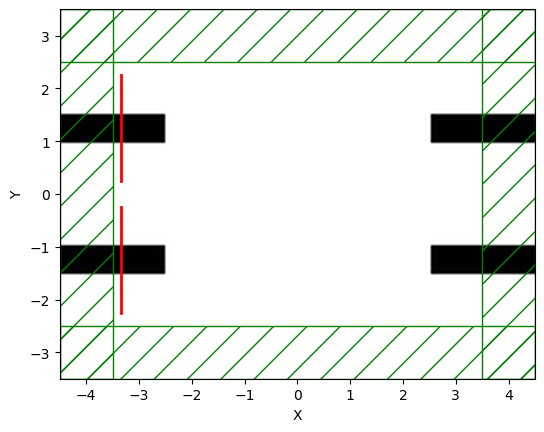

In [4]:
Sx = 2*pml_size + 2*waveguide_length + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size + waveguide_length/3,-arm_separation/2,0]

src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]



# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]





geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top left waveguide
    mp.Block(center=mp.Vector3(x=-Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)
sim.plot2D()

In [5]:
def mapping(x,eta,beta):
    
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry
    
    # filter
    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)
    
    #filtered_field = mpa.cylindrical_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()

<Axes: xlabel='X', ylabel='Y'>

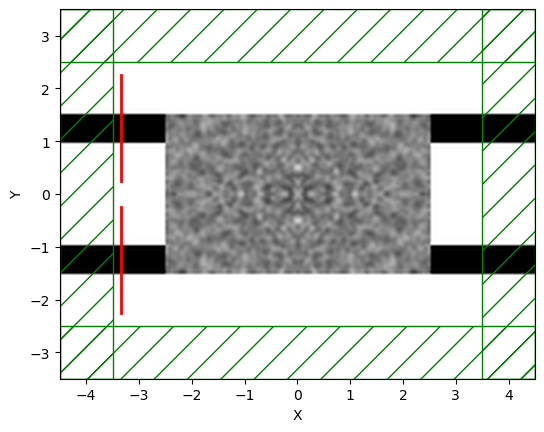

In [6]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,2))
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

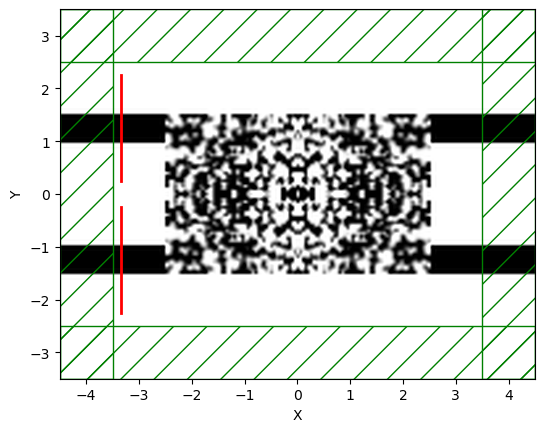

In [7]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,64))
sim.plot2D()

In [10]:
def straight_waveguide() -> (np.ndarray, NamedTuple):
    """Computes the DFT fields from the mode source in a straight waveguide
       for use as normalization of the reflectance measurement during the
       optimization.

    Returns:
      A 2-tuple consisting of a 1d array of DFT fields and DFT fields object
      returned by `meep.get_flux_data`.
    """

 

    Sx = 2*pml_size + 3 +1 # cell size in X
    Sy = 2*pml_size + 4*waveguide_width  # cell size in Y

    refl_pt =mp.Vector3(Sx/2 - pml_size-0.1)
    stop_cond = mp.stop_when_fields_decayed(50, mp.Ez, refl_pt, 1e-8)

    cell_size = mp.Vector3(Sx,Sy)

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            size=source_size,
            center=mp.Vector3(x= -Sx/2 + pml_size + 0.1),
            eig_band=1,
        )
    ]

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, waveguide_width),
            center=mp.Vector3(),
            material=Si,
        )
    ]

    sim = mp.Simulation(
        resolution=resolution,
        default_material=mp.air,
        cell_size=cell_size,
        sources=sources,
        geometry=geometry,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
    )

    refl_mon = sim.add_mode_monitor(
        frequencies,
        mp.ModeRegion(center= refl_pt, size=source_size),
        yee_grid=True,
    )

    sim.run(until_after_sources=stop_cond)

    res = sim.get_eigenmode_coefficients(
        refl_mon,
        [1],
    )

    coeffs = res.alpha
    input_flux = np.abs(coeffs[0, :, 0]) ** 2
    input_flux_data = sim.get_flux_data(refl_mon)

    return input_flux, input_flux_data

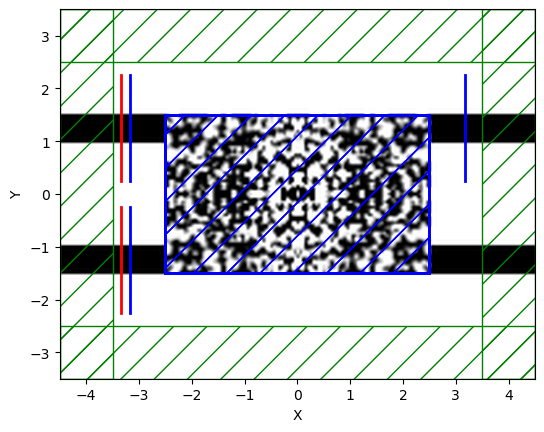

In [11]:
input_flux, input_flux_data = straight_waveguide()

mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 2*waveguide_length/3, y=arm_separation/2),
            size=source_size),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 2*waveguide_length/3,arm_separation/2,0),
            size=source_size),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 2*waveguide_length/3,-arm_separation/2,0),
            size=source_size),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(output,top_source,bottom_source):
    power = npa.abs(output) ** 2 / (2 * input_flux) 
    return npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

That's why we use "Phase injected topology optimization" ( Read more here: https://pubs.acs.org/doi/abs/10.1021/acsphotonics.2c01016)

In [ ]:
x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

#just for the same of a boundary value
x0=np.where(x0>1,1,x0)
x0=np.where(x0<0,0,x0)

#x0 = np.random.rand(Nx,Ny)
f0, g0 = opt([mapping(x0,0.5,2)])

In [ ]:
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

In [ ]:
from autograd import tensor_jacobian_product
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()

In [13]:
import nlopt
evaluation_history = []
cur_iter = [0]
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    
    f0, dJ_du = opt([mapping(v,eta_i,cur_beta)])
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    ax.axis('off')
    plt.show()
    
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v,eta_i,cur_beta,np.sum(dJ_du,axis=1))
    
    evaluation_history.append(np.max(np.real(f0)))
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

In [14]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5 # + np.random.normal(loc=mean, scale=std, size=(n,))
#x = np.random.rand(n,) 

#just for the same of boundary value
x=np.where(x>1,1,x)
x=np.where(x<0,0,x)

# lower and upper bounds
lb = 0
ub = 1

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 30
for iters in range(num_betas):
    print("current beta: ",cur_beta)
    
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale



update_factor = 70
num_beta=1
print("----------------------------------------------------------------")
print('final binarization')
    
for iters in range(num_betas): # the main beta increment loop
    print("current beta: ",cur_beta)
    
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x) # iterates update_factor times
    cur_beta = cur_beta*beta_scale

current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...


/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [ ]:
#################################################
#SAVE THE design_region (x)
#################################################

np.save("design_15x4.npy",x)

In [ ]:
plt.matshow(x)

In [ ]:
plt.figure()
plt.plot(10*np.log10(np.array(1-evaluation_history)),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Insertion loss (dB)')
plt.show()

In [ ]:

src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1)]



sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)


mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3, y=arm_separation/2),
            size=mp.Vector3(y=2)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,-arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J2(input,top_output,bottom_output):
    power = npa.abs(top_output/input) ** 2 + npa.abs(bottom_output/input) ** 2 
    return npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J2,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)

In [ ]:
f0, dJ_du = opt([mapping(x,eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2


In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,1-(np.abs(top_coef) ** 2 + np.abs(bottom_ceof) ** 2)/np.abs(source_coef) ** 2,'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_ceof) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
opt.sim.change_sources(source)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [ ]:
filename = "dc_2d_15x4_1s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "dc_2d_15x4_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
